# ARIMA model 

- Temperature Dataset

### Step 1: Importing neccesary libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Step 2: Load the dataset

In [17]:
# Load the dataset
data = pd.read_csv('temperature.csv')

### Step 3: Data Preprocessing

In [18]:
# Convert the 'Datetime' column to a datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Set the 'Datetime' column as the DataFrame index
data.set_index('Datetime', inplace=True)


In [19]:
data

,Unnamed: 0,Hourly_Temp
Datetime,,
2022-01-04 00:00:00,0,20.867
2022-01-04 01:00:00,1,21.000
2022-01-04 02:00:00,2,20.867
2022-01-04 03:00:00,3,20.650
2022-01-04 04:00:00,4,20.400
...,...,...
2022-10-24 19:00:00,7051,25.567
2022-10-24 20:00:00,7052,25.183
2022-10-24 21:00:00,7053,24.600


### Step 4: Data Visualization

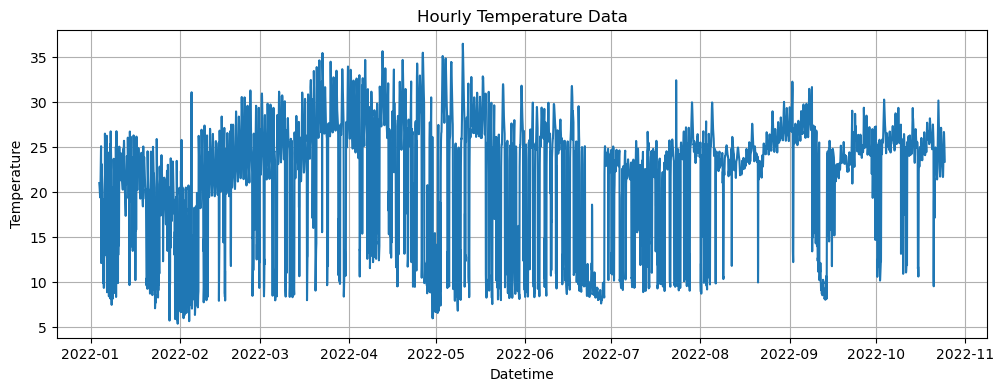

In [30]:
# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(data['Hourly_Temp'])
plt.title('Hourly Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()


### Step 5: Check Stationarity

In [31]:
# Define a function to check stationarity and perform differencing
def test_stationarity(timeseries):
    # Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    return dfoutput

# Check stationarity
result = test_stationarity(data['Hourly_Temp'])
print("Augmented Dickey-Fuller Test:")
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                -9.395836e+00
p-value                        6.378229e-16
#Lags Used                     2.500000e+01
Number of Observations Used    7.029000e+03
Critical Value (1%)           -3.431281e+00
Critical Value (5%)           -2.861951e+00
Critical Value (10%)          -2.566989e+00
dtype: float64


### Step 6: Perform Differencing

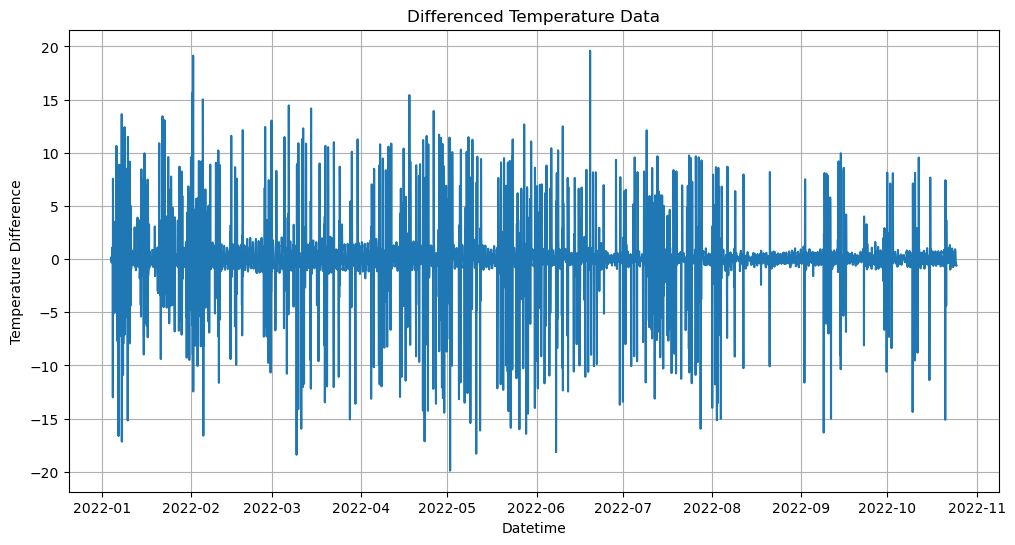

In [22]:
# Differencing to make the series stationary
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data.dropna(inplace=True)

# Plot differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Differenced Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()

### Step 7: Check Stationarity of Differenced Data

In [23]:
# Check stationarity of differenced data
result = test_stationarity(data['Temp_Diff'])
print("Augmented Dickey-Fuller Test on Differenced Data:")
print(result)

Augmented Dickey-Fuller Test on Differenced Data:
Test Statistic                  -20.546080
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7019.000000
Critical Value (1%)              -3.431282
Critical Value (5%)              -2.861952
Critical Value (10%)             -2.566989
dtype: float64


### Step 8: Fit SARIMA Model

In [24]:
# Fit SARIMA model
model = SARIMAX(data['Hourly_Temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
results = model.fit(disp=False)

### Step 9: Forecast Future Values

In [25]:
# Forecast future values
forecast_steps = 24  # Adjust this as needed
forecast = results.get_forecast(steps=forecast_steps)


In [34]:
# data.tail()

### Step 10: Create Date Range for Forecasting

In [32]:
# Create a date range for forecasting
date_range = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='H')
date_range

DatetimeIndex(['2022-10-24 23:00:00', '2022-10-25 00:00:00',
               '2022-10-25 01:00:00', '2022-10-25 02:00:00',
               '2022-10-25 03:00:00', '2022-10-25 04:00:00',
               '2022-10-25 05:00:00', '2022-10-25 06:00:00',
               '2022-10-25 07:00:00', '2022-10-25 08:00:00',
               '2022-10-25 09:00:00', '2022-10-25 10:00:00',
               '2022-10-25 11:00:00', '2022-10-25 12:00:00',
               '2022-10-25 13:00:00', '2022-10-25 14:00:00',
               '2022-10-25 15:00:00', '2022-10-25 16:00:00',
               '2022-10-25 17:00:00', '2022-10-25 18:00:00',
               '2022-10-25 19:00:00', '2022-10-25 20:00:00',
               '2022-10-25 21:00:00', '2022-10-25 22:00:00',
               '2022-10-25 23:00:00'],
              dtype='datetime64[ns]', freq='h')

### Step 11: Get Forecasted Values and Confidence Intervals

In [27]:
# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

### Step 12: Create a Forecast DataFrame

In [28]:
# Create a forecast DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast_values, 'Lower_CI': forecast_conf_int.iloc[:, 0], 'Upper_CI': forecast_conf_int.iloc[:, 1]}, index=date_range[1:])

### Step 13: Plot the Original Data and the Forecast

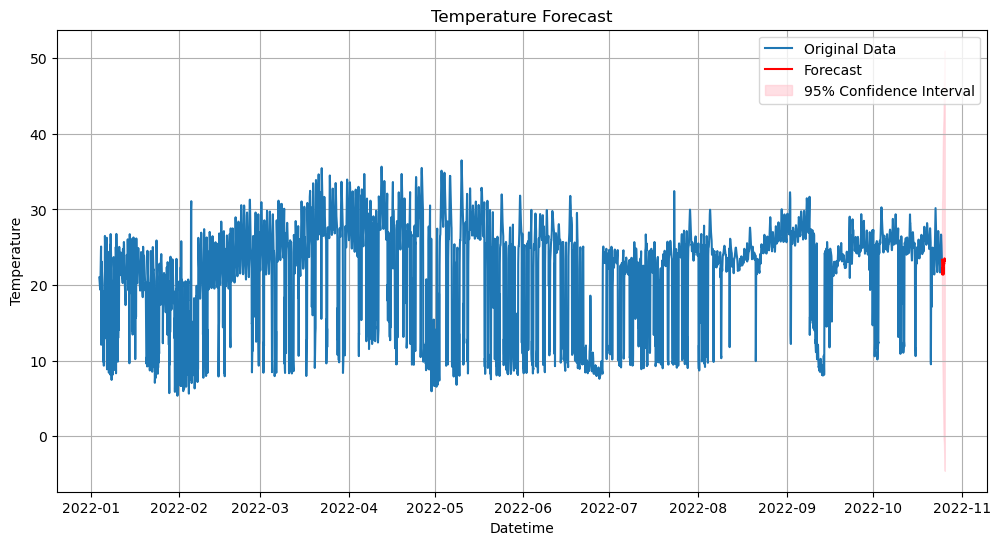

In [29]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'], label='Original Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('Temperature Forecast')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()